# Business and data understanding - ethereum - v1

## Purpose
Entender o [DataverseNL (2021). Detection of illicit accounts over the Ethereum blockchain](http://doi.org/10.34894/GKAQYN).

# Setup

## Library import
We import all the required Python libraries

In [2]:
import os

# Data manipulation
from feature_engine.encoding import RareLabelEncoder, CountFrequencyEncoder
import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np

# Visualizations
import plotly
import plotly.graph_objs as go
import plotly.offline as ply
plotly.offline.init_notebook_mode(connected=True)
import matplotlib as plt
import seaborn as sns

import missingno as msno
from pycaret.classification import ClassificationExperiment
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from ydata_profiling import ProfileReport

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2

# Options for pandas
# pd.options.display.max_columns = None
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.float_format', '{:.5f}'.format)
# pd.options.display.float_format = '{:.5f}'.format
# pd.options.display.max_rows = 120

sns.set_context(context='paper', font_scale=1, rc=None)
sns.set_style("ticks")
sns.set_palette(sns.color_palette())

## Local library import
We import all the required local libraries libraries

In [3]:
os.chdir('../')
from src.utils.data_describe import breve_descricao, serie_nulos, cardinalidade, check_for_equal_columns
os.chdir('./notebooks/')

def is_numeric(col):
    try:
        pd.to_numeric(col)
        return True
    except:
        return False

# Parameter definition
We set all relevant parameters for our notebook. By convention, parameters are uppercase, while all the 
other variables follow Python's guidelines.

In [4]:
RAW_FOLDER = '../data/raw/'
INTERIM_FOLDER = '../data/interim/'
PROCESSED_FOLDER = '../data/processed/'
REPORTS_FOLDER = '../reports/'
RANDOM_STATE = 42


# Data import
We retrieve all the required data for the analysis.

In [5]:
try:
    df_raw = pd.read_parquet(INTERIM_FOLDER + 'ethereum_complete.pqt')
    print(f'PARQUET file loaded. Shape: {df_raw.shape}')
except FileNotFoundError as e:
    df_raw = pd.read_csv(RAW_FOLDER + 'ethereum_complete.csv')
    df_raw.drop(columns=['Index'], inplace=True)
   
    df_raw.to_parquet(INTERIM_FOLDER +  'ethereum_complete.pqt', index=False)
    print(f'EXCEL file loaded and PARQUET created. Shape: {df_raw.shape}')

PARQUET file loaded. Shape: (4681, 49)


In [6]:
display(df_raw.head(3))

,Address,FLAG,Avg_min_between_sent_tnx,Avg_min_between_received_tnx,Time_Diff_between_first_and_last_(Mins),Sent_tnx,Received_Tnx,Number_of_Created_Contracts,Unique_Received_From_Addresses,Unique_Sent_To_Addresses,min_value_received,max_value_received,avg_val_received,min_val_sent,max_val_sent,avg_val_sent,min_value_sent_to_contract,max_val_sent_to_contract,avg_value_sent_to_contract,total_transactions_(including_tnx_to_create_contract),total_Ether_sent,total_ether_received,total_ether_sent_contracts,total_ether_balance,Total_ERC20_tnxs,ERC20_total_Ether_received,ERC20_total_ether_sent,ERC20_total_Ether_sent_contract,ERC20_uniq_sent_addr,ERC20_uniq_rec_addr,ERC20_uniq_sent_addr.1,ERC20_uniq_rec_contract_addr,ERC20_avg_time_between_sent_tnx,ERC20_avg_time_between_rec_tnx,ERC20_avg_time_between_rec_2_tnx,ERC20_avg_time_between_contract_tnx,ERC20_min_val_rec,ERC20_max_val_rec,ERC20_avg_val_rec,ERC20_min_val_sent,ERC20_max_val_sent,ERC20_avg_val_sent,ERC20_min_val_sent_contract,ERC20_max_val_sent_contract,ERC20_avg_val_sent_contract,ERC20_uniq_sent_token_name,ERC20_uniq_rec_token_name,ERC20_most_sent_token_type,ERC20_most_rec_token_type
0,0x0020731604c882cf7bf8c444be97d17b19ea4316,1,1457.31000,34.12000,4815.43000,3,13,0,10,3,1.00000,2.50105,1.34844,1.00087,11.27787,5.84292,0,0,0,16,17.52875,17.52978,0,0.00104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
1,0x002bf459dc58584d58886169ea0e80f3ca95ffaf,1,3976.50000,834.77000,9622.53000,2,2,0,1,2,0.58627,0.94751,0.76689,0.58541,0.94728,0.76635,0,0,0,4,1.53269,1.53378,0,0.00109,1.00000,1.33700,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.33700,1.33700,1.33700,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,,Blockwell say NOTSAFU
2,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,1,112.90000,31.87000,321.42000,2,3,0,3,1,0.00102,0.81780,0.43961,0.50039,0.81751,0.65895,0,0,0,5,1.31790,1.31882,0,0.00092,1.00000,1.33700,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.33700,1.33700,1.33700,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,,Blockwell say NOTSAFU


# Data evaluation

## Cardinality and null values

In [7]:
df_evaluation = df_raw.copy()

# lst_duplicated_columns = [
#     'ERC20_uniq_sent_addr.1', 'ERC20_avg_time_between_rec_2_tnx', 'ERC20_avg_val_sent_contract',
#     'ERC20_max_val_sent_contract', 'ERC20_min_val_sent_contract',
# ]

# df_evaluation.drop(columns=lst_duplicated_columns, inplace=True)

In [8]:
i = j = 0

for column in df_evaluation.columns:
    if is_numeric(df_evaluation[column]):
        i += 1
        print(f'column: {column} - numeric {i}')
    else:
        print(f'column: {column} - not numeric {j}')


column: Address - not numeric 0
column: FLAG - numeric 1
column: Avg_min_between_sent_tnx - numeric 2
column: Avg_min_between_received_tnx - numeric 3
column: Time_Diff_between_first_and_last_(Mins) - numeric 4
column: Sent_tnx - numeric 5
column: Received_Tnx - numeric 6
column: Number_of_Created_Contracts - numeric 7
column: Unique_Received_From_Addresses - numeric 8
column: Unique_Sent_To_Addresses - numeric 9
column: min_value_received - numeric 10
column: max_value_received - numeric 11
column: avg_val_received - numeric 12
column: min_val_sent - numeric 13
column: max_val_sent - numeric 14
column: avg_val_sent - numeric 15
column: min_value_sent_to_contract - numeric 16
column: max_val_sent_to_contract - numeric 17
column: avg_value_sent_to_contract - numeric 18
column: total_transactions_(including_tnx_to_create_contract) - numeric 19
column: total_Ether_sent - numeric 20
column: total_ether_received - numeric 21
column: total_ether_sent_contracts - numeric 22
column: total_ethe

In [9]:
is_numeric_dtype(df_evaluation['min_value_sent_to_contract'])

True

In [10]:
lst_numeric_columns = df_evaluation.select_dtypes(exclude=object).columns.tolist()
lst_numeric_columns.remove('FLAG')
print(len(lst_numeric_columns), lst_numeric_columns)

45 ['Avg_min_between_sent_tnx', 'Avg_min_between_received_tnx', 'Time_Diff_between_first_and_last_(Mins)', 'Sent_tnx', 'Received_Tnx', 'Number_of_Created_Contracts', 'Unique_Received_From_Addresses', 'Unique_Sent_To_Addresses', 'min_value_received', 'max_value_received', 'avg_val_received', 'min_val_sent', 'max_val_sent', 'avg_val_sent', 'min_value_sent_to_contract', 'max_val_sent_to_contract', 'avg_value_sent_to_contract', 'total_transactions_(including_tnx_to_create_contract)', 'total_Ether_sent', 'total_ether_received', 'total_ether_sent_contracts', 'total_ether_balance', 'Total_ERC20_tnxs', 'ERC20_total_Ether_received', 'ERC20_total_ether_sent', 'ERC20_total_Ether_sent_contract', 'ERC20_uniq_sent_addr', 'ERC20_uniq_rec_addr', 'ERC20_uniq_sent_addr.1', 'ERC20_uniq_rec_contract_addr', 'ERC20_avg_time_between_sent_tnx', 'ERC20_avg_time_between_rec_tnx', 'ERC20_avg_time_between_rec_2_tnx', 'ERC20_avg_time_between_contract_tnx', 'ERC20_min_val_rec', 'ERC20_max_val_rec', 'ERC20_avg_val_r

In [11]:
df_cardinalidade = cardinalidade(
    df_evaluation.drop(columns=['Address', 'FLAG'])
).sort_values(by='Proporção Nulos', ascending=False)
df_cardinalidade.sort_values(by=['Proporção Nulos'], ascending=False)

,Atributo,DType,Cardinalidade,Valores,Proporção Nulos
ERC20_most_rec_token_type,ERC20_most_rec_token_type,object,280,"[, , 0, A2A(B) STeX Exchange Token, ABCC invite, AI Gaming Coin, AICRYPTO, AION, ARP, ATLANT, ATN, AdEx, Aeternity, AirCoin, Amber, Amplify, An Etheal Promo, AppCoins, Aragon, ArtisTurba, Asobicoin promo, Authoreon, Authorship, Azbit, BAT, BAX, BBN, BCShareS, BOX Token, BUZCOIN, Bancor, Beauty Coin, BeautyChain, BigBang Game Coin Token, BinaryCoin, BitAir, BitClave, Bitcoin EOS, BizCoin, Blockwell say NOTSAFU, Blupee, Bounty, Bulleon Promo Token, CANDY, CGW, CIChain, CRYPTOPUNKS, Cai Token, CargoX, Carrots, Cashaa, Celer Network, Centra, ChainLink Token, Civic, CoinBene Coin, CoinDash, Coineal Token, CosmoCoin, Crypterium, Crypto.com, Cryptonex, CyberMiles, Cybereits Token, DALECOIN, DATAcoin, DCORP, DEBITUM, DEW, DGD, DICE, DIGIBYTE, DMTS, Dai Stablecoin v1.0, Dao.Casino, Data, Decentraland, Delphy Token, Digital Developers Fund Token, Dragon, Dropil, EBCoin, ECHARGE, ELF, EMO tokens, EOS, ERC20, ESSENTIA, EasyEosToken, Edgeless, ElectrifyAsia, Electronic Energy Coin, Energem, EnjinCoin, Enumivo, Ethbits, EtherEcash, Ethereum, Ethos, Everest, ...]",0.17859
ERC20_most_sent_token_type,ERC20_most_sent_token_type,object,172,"[, , '', 0, 21Million, AION, ARBITRAGE, AVT, AdEx, Adshares, Aeternity, AirToken, Aragon, Authorship, BAT, BCShareS, BNB, BTOCoin, BUZCOIN, Bancor, BinaryCoin, BitDice, BizCoin, Blackmoon Crypto Token, Bounty0x, Brickblock, Bytom, CANDY, CRYPTOPUNKS, CarTaxi, Cashaa, ChainLink Token, CharterCoin, Civic, Cofoundit, CoinDash, Crypterium, Crypto.com, DADI, DATAcoin, DGD, DICE, Dao.Casino, Decent.Bet Token, Decentraland, Digital Developers Fund Token, Digix Gold Token, EDT, EOS, ERC20, ETHWrapper, Electronic Energy Coin, EnjinCoin, Ether, Ethos, Fair Token, Fantom Token, Feed, Fortecoin, Friendz Coin, FunFair, GECoin, GRID, Gemini dollar, Gnosis, Golem, Guppy, Happy Coin, Hawala, Humaniq, HuobiPoolToken, HuobiToken, Hydro, IBCCoin, ICO, ICON, ICONOMI, IDICE, IOSToken, IOT Chain, IUNGO, Identity Hub Token, KickCoin, KyberNetwork, Litecoin One, Livepeer Token, Loopring, Lucky Token, Lunyr, MCAP, MEX, Magna, Master Coin, Mavrodi, Merculet, Mithril Token, MobileGo, Monetha, NOAHCOIN, NaN, ...]",0.17731
ERC20_total_ether_sent,ERC20_total_ether_sent,float64,447,"[0.0, 112000000000.0]",0.17710
Total_ERC20_tnxs,Total_ERC20_tnxs,float64,199,"[0.0, 10000.0]",0.17710
ERC20_total_Ether_sent_contract,ERC20_total_Ether_sent_contract,float64,22,"[0.0, 416000.0]",0.17710
ERC20_uniq_rec_token_name,ERC20_uniq_rec_token_name,float64,100,"[0.0, 435.0]",0.17710
ERC20_uniq_sent_token_name,ERC20_uniq_sent_token_name,float64,58,"[0.0, 125.0]",0.17710
ERC20_avg_val_sent_contract,ERC20_avg_val_sent_contract,float64,2,"[nan, 0.0]",0.17710
ERC20_max_val_sent_contract,ERC20_max_val_sent_contract,float64,2,"[nan, 0.0]",0.17710
ERC20_min_val_sent_contract,ERC20_min_val_sent_contract,float64,2,"[nan, 0.0]",0.17710


In [13]:
# df_evaluation.drop(columns=['Address', 'FLAG'], inplace=True)

df_cardinalidade = cardinalidade(
    df_evaluation.select_dtypes(exclude=object)
).sort_values(by='Proporção Nulos', ascending=False)
df_cardinalidade.sort_values(by=['Proporção Nulos'], ascending=False)
# .to_excel(PROCESSED_FOLDER + 'cardinalidade_numerico.xlsx')

,Atributo,DType,Cardinalidade,Valores,Proporção Nulos
Total_ERC20_tnxs,Total_ERC20_tnxs,float64,199,"[0.0, 10000.0]",0.17710
ERC20_max_val_rec,ERC20_max_val_rec,float64,990,"[0.0, 1000000000000.0]",0.17710
ERC20_total_Ether_received,ERC20_total_Ether_received,float64,1300,"[0.0, 1000000000000.0]",0.17710
ERC20_uniq_rec_token_name,ERC20_uniq_rec_token_name,float64,100,"[0.0, 435.0]",0.17710
ERC20_total_ether_sent,ERC20_total_ether_sent,float64,447,"[0.0, 112000000000.0]",0.17710
ERC20_uniq_sent_token_name,ERC20_uniq_sent_token_name,float64,58,"[0.0, 125.0]",0.17710
ERC20_avg_val_sent_contract,ERC20_avg_val_sent_contract,float64,2,"[nan, 0.0]",0.17710
ERC20_max_val_sent_contract,ERC20_max_val_sent_contract,float64,2,"[nan, 0.0]",0.17710
ERC20_avg_val_sent,ERC20_avg_val_sent,float64,414,"[0.0, 56147560976.0]",0.17710
ERC20_max_val_sent,ERC20_max_val_sent,float64,385,"[0.0, 112000000000.0]",0.17710


In [14]:
# List of columns with cardinality equals to 1
df_cardinalidade.loc[df_cardinalidade['Proporção Nulos']>0.1, 'Atributo'].values.tolist()

lst_with_null = df_cardinalidade.loc[df_cardinalidade['Proporção Nulos']>0.1, 'Atributo'].values.tolist()

In [15]:
lst_unitary_columns = df_cardinalidade[df_cardinalidade['Cardinalidade']==1].index.tolist()
lst_unitary_columns

['min_value_sent_to_contract',
 'max_val_sent_to_contract',
 'avg_value_sent_to_contract',
 'total_ether_sent_contracts']

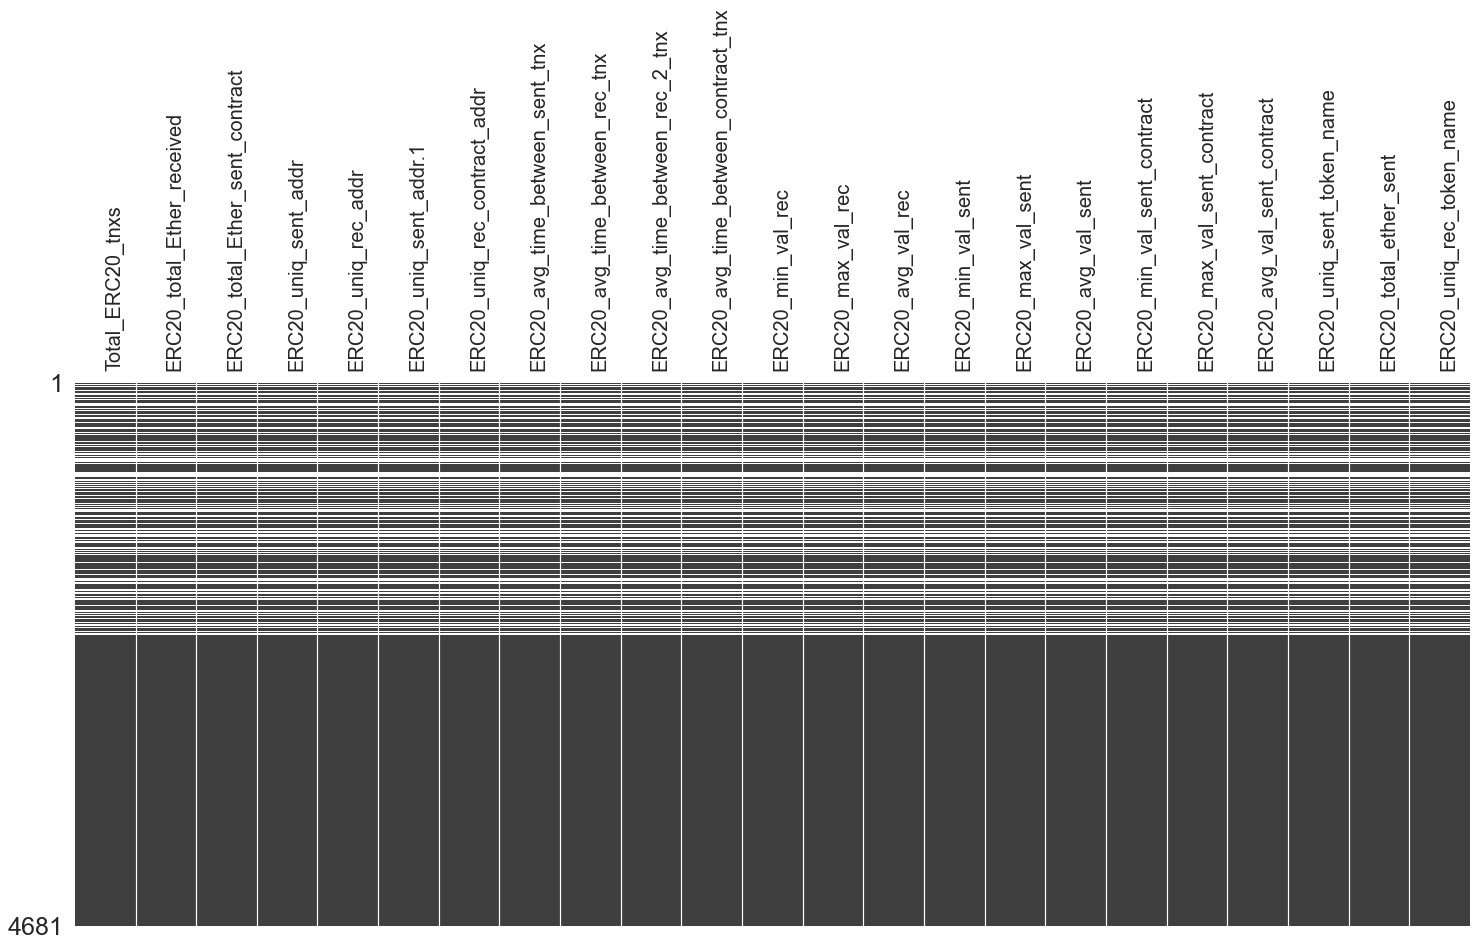

In [16]:
msno.matrix(df_raw[lst_with_null], fontsize=20, label_rotation=90, sparkline=False);

## Checking columns that are equal

In [ ]:
check_for_equal_columns(df_evaluation)

In [ ]:
lst_equal_columns = check_for_equal_columns(df_evaluation).index.tolist()
lst_equal_columns_keep = check_for_equal_columns(df_evaluation).drop_duplicates(keep='last').index.values.tolist()

for column in lst_equal_columns_keep:
    lst_equal_columns.remove(column)

lst_equal_columns

## Categorical features

In [ ]:
df_evaluation_categorical = df_evaluation.select_dtypes(include='object').drop(columns='Address')
df_evaluation_categorical.head()

### ERC20_most_sent_token_type

In [ ]:
pd.DataFrame(
    100*df_evaluation_categorical.loc[:, 'ERC20_most_sent_token_type'].value_counts()/df_evaluation_categorical.loc[:, 'ERC20_most_sent_token_type'].value_counts().sum()
).to_excel(PROCESSED_FOLDER + 'teste.xlsx', engine='xlsxwriter')

In [ ]:
(
    100*df_evaluation_categorical.loc[:, 'ERC20_most_sent_token_type'].value_counts()/
    df_evaluation_categorical.loc[:, 'ERC20_most_sent_token_type'].value_counts().sum()
).head(10).plot(kind='barh');

#### Replacing " " and "0" to "no information"

In [ ]:
for column in ['ERC20_most_sent_token_type']:
    df_evaluation_categorical.loc[df_evaluation_categorical[column].isnull(), column] = "0"
    for category in [" ", "", "0"]:
        df_evaluation_categorical[column] = df_evaluation_categorical[column].str.strip()
        df_evaluation_categorical[column].replace(category, "no information", inplace=True)

pd.DataFrame(
    100*df_evaluation_categorical.loc[:, column].value_counts()/df_evaluation_categorical.loc[:, column].value_counts().sum()
).head(10).plot(kind='barh');

### ERC20_most_rec_token_type

In [ ]:
(
    100*df_evaluation_categorical.loc[:, 'ERC20_most_rec_token_type'].value_counts()/
    df_evaluation_categorical.loc[:, 'ERC20_most_rec_token_type'].value_counts().sum()
).head(10).plot(kind='barh');

In [ ]:
pd.DataFrame(
    100*df_evaluation_categorical.loc[:, 'ERC20_most_rec_token_type'].value_counts()/\
    df_evaluation_categorical.loc[:, 'ERC20_most_rec_token_type'].value_counts().sum()
).to_excel(PROCESSED_FOLDER + 'ERC20_most_rec_token_type.xlsx', engine='xlsxwriter')

#### Replacing " " and "0" to "no information"

In [ ]:
for column in ['ERC20_most_rec_token_type']:
    df_evaluation_categorical.loc[df_evaluation_categorical[column].isnull(), column] = "0"
    for category in [" ", "", "0"]:
        df_evaluation_categorical[column] = df_evaluation_categorical[column].str.strip()
        df_evaluation_categorical[column].replace(category, "no information", inplace=True)

pd.DataFrame(
    100*df_evaluation_categorical.loc[:, column].value_counts()/df_evaluation_categorical.loc[:, column].value_counts().sum()
).head(10).plot(kind='barh');

## Auto EDA with ydata

In [12]:
profile = ProfileReport(
    df_evaluation[lst_numeric_columns].sample(100, random_state=RANDOM_STATE),
    title="Profiling Report")

# profile.to_file(REPORTS_FOLDER + 'data_analysis_report.html')
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

## Conclusion

1. O *dataset* original continha 49 atributos. Excluindo-se as colunas de **Address** e **FLAG**, chegamos a 47. Há 5 colunas a mais do que o indicado no artigo. Isso deve-se:
    - **ERC20_uniq_sent_addr.1** NÃO existe originalmente, talvez tenha havido alguma duplicação com transformação da coluna **ERC20_uniq_sent_addr**.
    - **ERC20_avg_time_between_rec_2_tnx** NÃO existe originalmente, talvez tenha havido alguma duplicação sem transformação da coluna **ERC20_avg_time_between_rec_tnx**.
    - **ERC20_avg_val_sent_contract** NÃO existe originalmente, talvez tenha havido alguma duplicação com transformação da coluna **ERC20_avg_val_sent**
    - **ERC20_max_val_sent_contract** NÃO existe originalmente, talvez tenha havido alguma duplicação com transformação da coluna **ERC20_max_val_sent**
    - **ERC20_min_val_sent_contract** NÃO existe originalmente, talvez tenha havido alguma duplicação com transformação da coluna **ERC20_min_val_sent**

---

2. Colunas com cardinalidade igual a 1. Quatro colunas possuem cardinalidade igual a 1 e, portanto, NÃO adicionam nenhuma informação para a classificação das carteiras:
    - **'avg_value_sent_to_contract'**,
    - **'max_val_sent_to_contract'**,
    - **'total_ether_sent_contracts'**,
    - **'min_value_sent_to_contract'**

---

3. Há 2 grupos de colunas que são idênticos e, portanto, podemos remover os idênticos e manter apenas um de cada grupo:
    - **'min_value_sent_to_contract'**, **'max_val_sent_to_contract'**, **'avg_value_sent_to_contract'**, **'total_ether_sent_contracts'** -> Manteremos **'total_ether_sent_contracts'**
    - **'ERC20_avg_time_between_sent_tnx'**, **'ERC20_avg_time_between_rec_tnx'**, **'ERC20_avg_time_between_contract_tnx'** -> Manteremos **'ERC20_avg_time_between_contract_tnx'**

---

4. Há dois atributos categóricos (**ERC20_most_sent_token_type** e **ERC20_most_rec_token_type**). Esses atributos passarão pelas seguintes tratamentos e transformações:
    - Substituição de strings com espaços vazios (ex.: "    ") e "0" para string "no information";
    - *RareLabel*;
    - *CountFrequencyEncoder*

# Data cleaning

1. Remove duplicated registries
2. Remove duplicated columns
3. Remove constant columns
4. Remove equal columns
5. Transforming categorical features

## Removing duplicated registries

In [ ]:
df_cleaned = df_raw.copy()

In [ ]:
df_cleaned.drop_duplicates(inplace=True)

print(f'Shape before data cleasing: {df_raw.shape}')
print(f'After dropping duplicated rows: {df_cleaned.shape}')

In [ ]:
df_raw[df_raw['Address'].isin(
    df_raw['Address'].value_counts()[df_raw['Address'].value_counts()>1].index.tolist()
)].to_excel(PROCESSED_FOLDER + 'duplicated_accounts.xlsx')

In [ ]:
df_cleaned['Address'].value_counts().head(10)

## Removing duplicated columns

In [ ]:
df_cleaned.drop(columns=lst_duplicated_columns, inplace=True)

print(f'Shape before data cleasing: {df_raw.shape}')
print(f'After dropping duplicated columns: {df_cleaned.shape}')

## Removing constant columns

In [ ]:
df_cleaned.drop(columns=lst_unitary_columns, inplace=True)

print(f'Shape before data cleasing: {df_raw.shape}')
print(f'After dropping duplicated columns: {df_cleaned.shape}')

## Removing equal columns

In [ ]:
for column in lst_equal_columns:
    try:
        df_cleaned.drop(columns=column, inplace=True)
    except:
        print(f"'{column}' was exluded before.")

print(30*'-')
print(f'Shape before data cleasing: {df_raw.shape}')
print(f'After dropping duplicated columns: {df_cleaned.shape}')

## Pre-processing categorical features

# Testing with pycaret

## All features

In [ ]:
test_size = 0.15
train_size = 1 - test_size

lst_test_sample = df_cleaned.sample(int(test_size*len(df_cleaned)), random_state=RANDOM_STATE).index.values
lst_train_sample = df_cleaned.drop(index=lst_test_sample).index.values

print(f"""
test_size: {test_size}
test_sample (registries): {len(lst_test_sample)}

train_size: {train_size}
train_sample (registries): {len(lst_train_sample)}
""")

In [ ]:
df_cleaned.loc[lst_train_sample, :].head()

In [ ]:
exp = ClassificationExperiment()
exp.setup(
    df_cleaned.loc[lst_train_sample, :].drop(columns=['Address']),
    target='FLAG', train_size=train_size, session_id=RANDOM_STATE
);

In [ ]:
best = exp.compare_models()

In [ ]:
best

In [ ]:
exp.plot_model(best, plot='feature')

## Only numerical features

In [ ]:
exp = ClassificationExperiment()
exp.setup(
    df_cleaned.loc[lst_train_sample, df_cleaned.select_dtypes(exclude=['object']).columns],
    target='FLAG', train_size=train_size, session_id=RANDOM_STATE
);

In [ ]:
best = exp.compare_models()

In [ ]:
exp.plot_model(best, plot='feature')